In [11]:
from pathlib import Path

import numpy as np
import pandas as pd
import geopandas as gpd
import xarray as xr
import rioxarray as rxa

import matplotlib.pyplot as plt

from uavsar_pytools.snow_depth_inversion import phase_from_depth, depth_from_phase

from constants import tol

ncs_dir = Path('/bsuhome/zacharykeskinen/scratch/data/uavsar/ncs')
ds = xr.open_dataset(ncs_dir.joinpath('final_10_10.nc'))#.isel(x = slice(0, -1, 10), y = slice(0, -1, 10))

interval = pd.read_parquet('/bsuhome/zacharykeskinen/uavsar-validation/data/insitu/storm_boards.parq')
interval = gpd.GeoDataFrame(interval, geometry = gpd.points_from_xy(interval.longitude, interval.latitude), crs="EPSG:4326")

In [30]:
insitu = pd.read_parquet('/bsuhome/zacharykeskinen/uavsar-validation/data/insitu/all_difference.parq')
insitu = insitu[insitu.site_name != 'jackson']
insitu = gpd.GeoDataFrame(insitu, geometry = gpd.points_from_xy(insitu.lon, insitu.lat), crs="EPSG:4326")

# get insitu info
densities = np.zeros(len(ds.time1.data))
phases = np.zeros(len(ds.time1.data))
for i, time in enumerate(ds.time1.data):
    insitu_t = insitu[insitu.time1 == time]
    density = np.mean(insitu_t[['t1_density', 't2_density']].mean(axis = 1))
    densities[i] = density
    phases[i] = np.mean(phase_from_depth(insitu_t['dSWE']*997/density, insitu_t['inc'], density = insitu_t[['t1_density', 't2_density']].mean(axis = 1)))
densities = xr.DataArray(densities,
    coords = {'time1':ds.time1.data})
phases = xr.DataArray(phases,
    coords = {'time1':ds.time1.data})

ds['unw_atm'] = ds['unw'] - ds['delay']
ds['unw_atm'] = ds['unw_atm'] - (ds['unw_atm'].mean(dim = ['x','y']) - phases)
# ds['unw_atm'] = sub['unw_atm'] - (sub['unw_atm'].mean(dim = ['x','y']) - sub['model_d_swe'].mean(dim = ['x','y']))
unw_d_swe = depth_from_phase(ds['unw_atm'], ds['inc'], density = densities) * densities / 997
unw_d_sd = depth_from_phase(ds['unw_atm'], ds['inc'], density = densities)

No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.
No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.
No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.
No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.
No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.
No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.
No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.
No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.
No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.
No permittivity data provided -- calculating p

In [58]:
for i, r in interval.iterrows():
    try:
        uv_t = unw_d_swe.sel(time1 = r.date_t1, method = 'nearest', tolerance = '3 days')
        uv_t_sd = unw_d_sd.sel(time1 = r.date_t1, method = 'nearest', tolerance = '3 days')
        ds_t = ds.sel(time1 = r.date_t1, method = 'nearest', tolerance = '3 days')
    except KeyError:
        continue

    interval.loc[i, 'near_uv_swe'] = uv_t.sel(x = r.geometry.x, y = r.geometry.y, method = 'nearest', tolerance = tol)
    interval.loc[i, 'near_uv_sd'] = uv_t_sd.sel(x = r.geometry.x, y = r.geometry.y, method = 'nearest', tolerance = tol)
    x_slice = slice(r.geometry.x - 2*tol, r.geometry.x + 2*tol)
    y_slice = slice(r.geometry.y + 2*tol, r.geometry.y - 2*tol)
    interval.loc[i, 'uv_swe'] = uv_t_sd.sel(x = x_slice, y = y_slice).mean() * r.den / 997
    interval.loc[i, 'uv_sd'] = uv_t_sd.sel(x = x_slice, y = y_slice).mean()
    interval.loc[i, 'model_melt'] = ds_t.sel(x = x_slice, y = y_slice)['cum_melt'].mean()

(-0.04, 0.07)

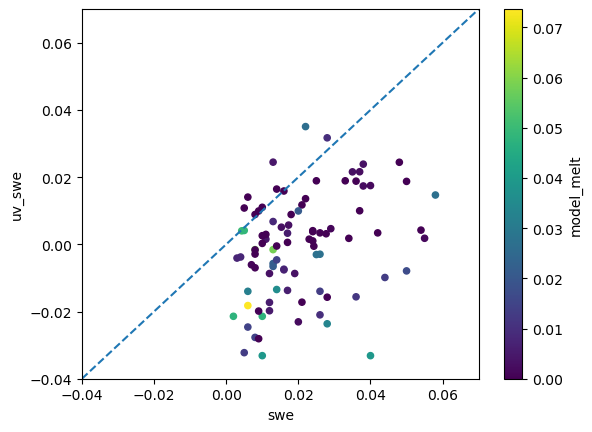

In [63]:
interval[interval.swe > 0].plot.scatter(x = 'swe', y = 'uv_swe', c = 'model_melt')
plt.plot([-0.04, 0.12],[-0.04, 0.12], linestyle = 'dashed')
plt.xlim(-0.04, 0.07)
plt.ylim(-0.04, 0.07)

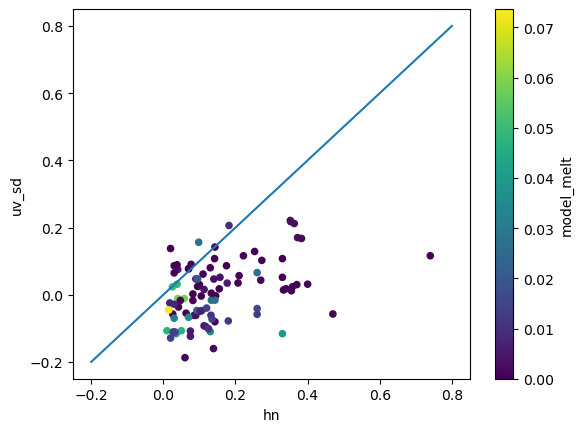

In [56]:
interval[interval.swe > 0].plot.scatter(x = 'hn', y = 'uv_sd', c = 'model_melt')
plt.plot([-0.2, 0.8],[-0.2, 0.8])

No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.


<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast


No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.


<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast


No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.


<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast


No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.


<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast


No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.


<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast


No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.


<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast


No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.


<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast


No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.


<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast


No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.


<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast


No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.


<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast


No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.


<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast


No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.


<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast


No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.


<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast


No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.


<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast


No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.


<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast


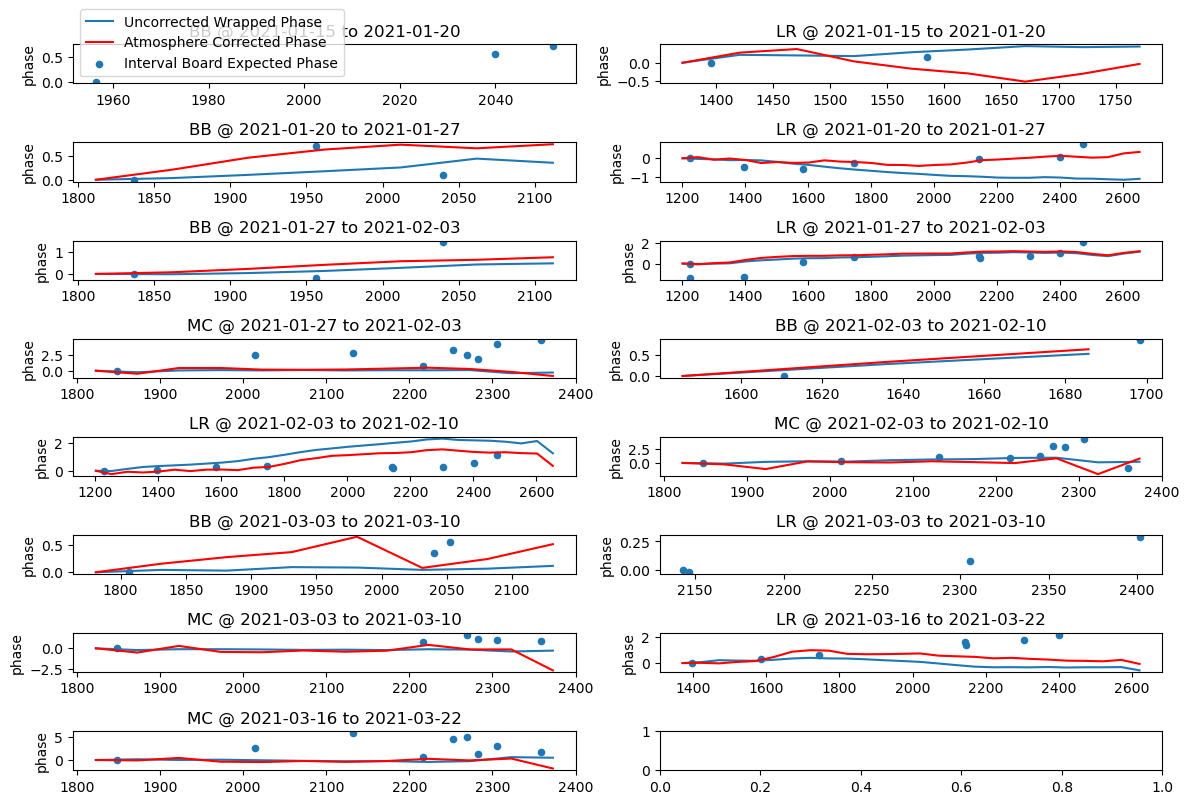

In [64]:
data_dir = Path('/bsuhome/zacharykeskinen/uavsar-validation/data')
insitu_dir = data_dir.joinpath('insitu')
insitu = pd.read_parquet(insitu_dir.joinpath('all_insitu.parq'))
boards = pd.read_parquet(insitu_dir.joinpath('storm_boards.parq'))
boards = gpd.GeoDataFrame(boards, geometry=gpd.points_from_xy(boards.longitude, boards.latitude), crs="EPSG:4326")
# add inc
for i, r in boards.iterrows():
    boards.loc[i, 'inc'] = ds.sel(x = r.geometry.x, y = r.geometry.y, method = 'nearest')['inc'].data.ravel()[0]
    boards.loc[i, 'elev'] = ds.sel(x = r.geometry.x, y = r.geometry.y, method = 'nearest')['dem'].data.ravel()[0]

interval_dir = Path('/bsuhome/zacharykeskinen/uavsar-validation/figures/interval')

fig, axes = plt.subplots(8, 2, figsize = (12, 8))
i = 0
for t1, t2 in zip(ds.time1.data, ds.time2.data):
    flight_boards = boards.loc[(boards.date_t2 <= t2 + pd.Timedelta('2 days')) & (boards.date_t1 >= t1 - pd.Timedelta('2 days')), :].copy()
    for site_id in ['BB','LR', 'MC']:
        flight_boards_site = flight_boards.loc[flight_boards.site.str.contains(site_id), :].copy()
        flight_boards_site = flight_boards_site.dropna(subset=['hn','den','inc'])
        xmin, ymin, xmax, ymax = flight_boards_site.total_bounds
        ds_site = ds.sel(x = slice(xmin, xmax), y = slice(ymax, ymin), time1 = t1)
        ds_site = ds_site.rolling(x = 5, y =5).mean()
        # ds_site = ds_site.where((ds_site['cor'] > 0.3))
        if ds_site.x.size > 1 and ds_site.y.size > 1 and len(flight_boards_site) > 1 and ds_site['int_phase'].isnull().sum() != ds_site['int_phase'].size:
            if i > 15:
                print('More than 8 subplots')
                break
            flight_boards_site = flight_boards_site.sort_values('elev')

            board_phase = phase_from_depth(flight_boards_site.hn.values, inc_angle=flight_boards_site.inc.values, density = flight_boards_site.den.values)
            board_phase = board_phase - board_phase[0]

            flight_boards_site.loc[:, 'phase'] = board_phase

            elev_phase = ds_site.groupby_bins('dem', np.arange(flight_boards_site.elev.min()-50, flight_boards_site.elev.max() + 250, 50)).mean()
            elev_phase = elev_phase - elev_phase.isel(dem_bins = 0)
            # elev_phase = elev_phase.rolling({'dem_bins': 3}, min_periods=1).mean()

            ax = axes.ravel()[i]
            elev_phase['int_phase'].plot(ax = ax, label = 'Uncorrected Wrapped Phase')
            (elev_phase['int_phase'] - elev_phase['delay']).plot(ax = ax, color = 'red', label = 'Atmosphere Corrected Phase')

            if i == 0:
                flight_boards_site.plot.scatter(x = 'elev', y = 'phase', ax = ax, label = 'Interval Board Expected Phase')
                ax.legend()
            else:
                flight_boards_site.plot.scatter(x = 'elev', y = 'phase', ax = ax)
            t1, t2 = pd.to_datetime(t1), pd.to_datetime(t2)
            ax.set_title(f"{site_id} @ {t1.strftime('%Y-%m-%d')} to {t2.strftime('%Y-%m-%d')}")
            ax.set_xlabel('')
            i += 1
plt.tight_layout()